# Robust transformer models
> test code for recent robust transformer models 

- toc: true 
- badges: true
- comments: true
- sticky_rank: 5
- author: Bowen
- categories: [transformer]

In [1]:
import mmcv
import matplotlib.pyplot as plt
from fastcore.basics import *
from fastai.vision.all import *
from fastai.torch_basics import *
import warnings
warnings.filterwarnings("ignore")
import kornia
from kornia.constants import Resample
from kornia.color import *
from kornia import augmentation as K
import kornia.augmentation as F
import kornia.augmentation.random_generator as rg
from torchvision.transforms import functional as tvF
from torchvision.transforms import transforms
from torchvision.transforms import PILToTensor

import matplotlib.pyplot as plt
import numpy as np

set_seed(105)

In [2]:

set_seed(105)
train_a_path = Path("/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/2_Ortho_RGB/")
label_a_path = Path("/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/5_labels_for_participants/")
dsm_path = Path("/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/1_dsm/1_DSM/")
ndsm_path = Path("/home/ubuntu/sharedData/swp/dlLab/fastaiRepository/fastai/data/rsData/kaggleOriginal/Potsdam/1_dsm_normalisation/1_DSM_normalisation/")
imgNames = get_image_files(train_a_path)
lblNames = get_image_files(label_a_path)
dsmNames = get_image_files(dsm_path)

In [3]:
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
rgbImage = Image.open(imgNames[0])
lblImage = Image.open(lblNames[0])
dsmImage = Image.open(dsmNames[0])
rgbTensor = image2tensor(rgbImage)
lblTensor = image2tensor(lblImage)
dsmTensor = image2tensor(dsmImage)
type(lblTensor)
rgbTensor.shape
lblTensor.shape
dsmTensor.shape
torch.unique(lblTensor)
lblTensor.shape

torch.Tensor

torch.Size([3, 6000, 6000])

torch.Size([1, 6000, 6000])

torch.Size([1, 6000, 6000])

tensor([0, 1, 2, 3, 4, 5], dtype=torch.uint8)

torch.Size([1, 6000, 6000])

In [4]:
(dsmImage).shape

(6000, 6000)

In [6]:
image2tensor(dsmImage)

tensor([[[31.8750, 31.8860, 31.8950,  ..., 32.5500, 32.5400, 32.5310],
         [31.8870, 31.8990, 31.9080,  ..., 32.5530, 32.5430, 32.5360],
         [31.8980, 31.9100, 31.9190,  ..., 32.5650, 32.5540, 32.5460],
         ...,
         [31.6260, 31.6290, 31.6310,  ..., 33.9540, 33.9500, 33.9360],
         [31.6290, 31.6320, 31.6350,  ..., 33.9260, 33.9230, 33.9070],
         [31.6320, 31.6350, 31.6380,  ..., 33.8970, 33.8940, 33.8770]]])

In [7]:
tempImg = dsmImage.convert("RGB")
tempImg.shape
temptensor =image2tensor(tempImg)
temptensor
temptensor.shape


(6000, 6000)

tensor([[[31, 31, 31,  ..., 32, 32, 32],
         [31, 31, 31,  ..., 32, 32, 32],
         [31, 31, 31,  ..., 32, 32, 32],
         ...,
         [31, 31, 31,  ..., 33, 33, 33],
         [31, 31, 31,  ..., 33, 33, 33],
         [31, 31, 31,  ..., 33, 33, 33]],

        [[31, 31, 31,  ..., 32, 32, 32],
         [31, 31, 31,  ..., 32, 32, 32],
         [31, 31, 31,  ..., 32, 32, 32],
         ...,
         [31, 31, 31,  ..., 33, 33, 33],
         [31, 31, 31,  ..., 33, 33, 33],
         [31, 31, 31,  ..., 33, 33, 33]],

        [[31, 31, 31,  ..., 32, 32, 32],
         [31, 31, 31,  ..., 32, 32, 32],
         [31, 31, 31,  ..., 32, 32, 32],
         ...,
         [31, 31, 31,  ..., 33, 33, 33],
         [31, 31, 31,  ..., 33, 33, 33],
         [31, 31, 31,  ..., 33, 33, 33]]], dtype=torch.uint8)

torch.Size([3, 6000, 6000])

## Towards Robust Vision Transformer

![](https://i.loli.net/2021/11/30/K5jhV2lZvu3oOki.png)
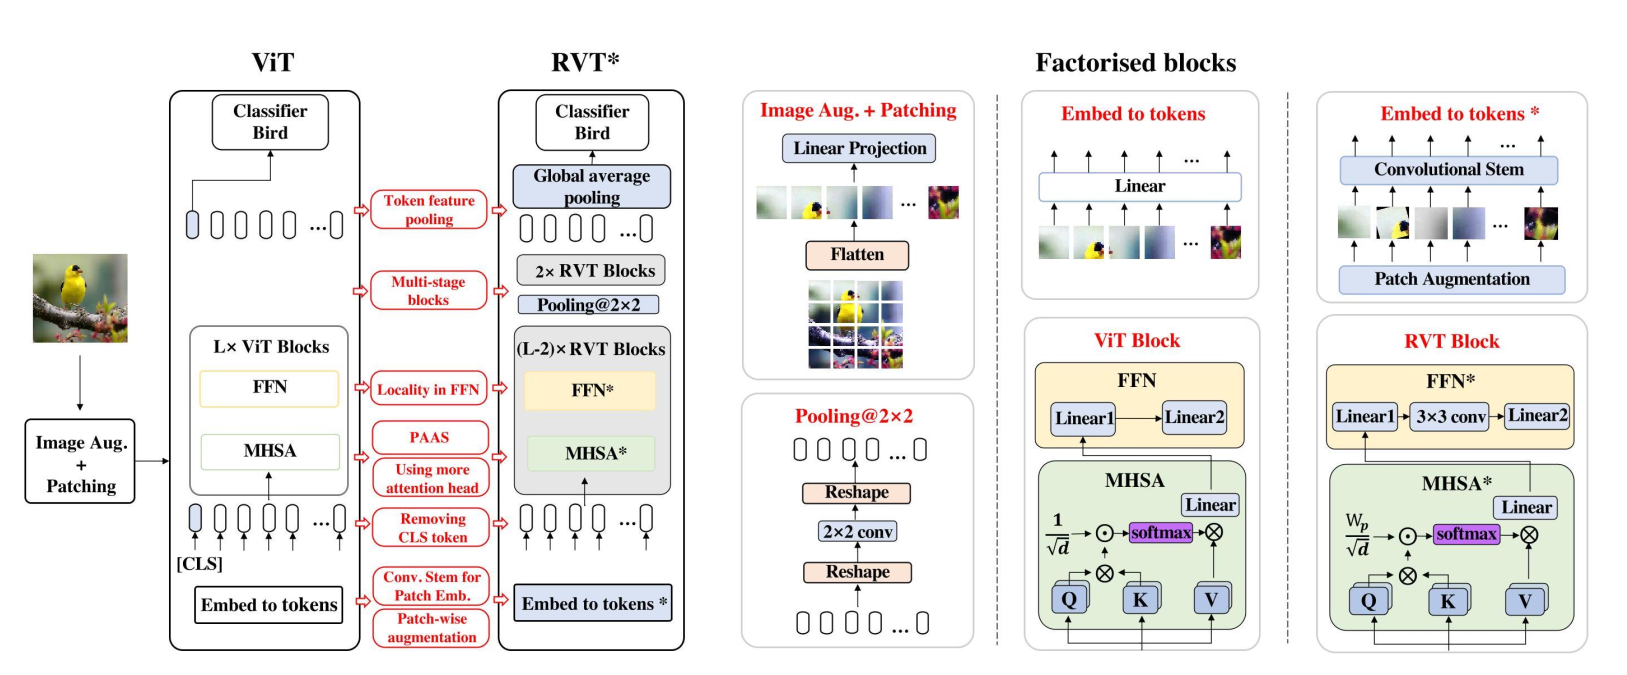

1) Extract low-level feature of patches using a convolutional stem; 
2)  Adopt the multi-stage design of ViTs and avoid blocks with larger spatial resolution; 
3)   Choose a suitable number of heads; 
4)   Use convolution in FFN; 
5)   Replace CLS token with token feature pooling.

In [4]:
from functools import partial
from timm.models.layers import trunc_normal_, DropPath
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.vision_transformer import _cfg
from einops import rearrange
from timm.models.registry import register_model

In [5]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.in_features = in_features
        if in_features == 768:
            self.fc1 = nn.Linear(in_features, hidden_features)
            self.act = act_layer()
            self.fc2 = nn.Linear(hidden_features, out_features)
            self.drop = nn.Dropout(drop)
        else:
            self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
            self.bn1 = nn.BatchNorm2d(hidden_features)
            self.dwconv = nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features)
            self.bn2 = nn.BatchNorm2d(hidden_features)
            self.act = act_layer()
            self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
            self.bn3 = nn.BatchNorm2d(out_features)
            self.drop = nn.Dropout(drop)

    def forward(self, x):
        if self.in_features == 768:
            x = self.fc1(x)
            x = self.act(x)
            x = self.drop(x)
            x = self.fc2(x)
            x = self.drop(x)
        else:
            B,N,C = x.shape
            x = x.reshape(B, int(N**0.5), int(N**0.5), C).permute(0,3,1,2)
            x = self.bn1(self.fc1(x))
            x = self.act(x)
            x = self.drop(x)
            x = self.act(self.bn2(self.dwconv(x)))
            x = self.bn3(self.fc2(x))
            x = self.drop(x)
            x = x.permute(0,2,3,1).reshape(B, -1, C)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., use_mask=False):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.use_mask = use_mask
        if use_mask:
            self.att_mask = nn.Parameter(torch.Tensor(self.num_heads, 196, 196))

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        if self.use_mask:
            attn = attn * torch.sigmoid(self.att_mask).expand(B, -1, -1, -1)

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, use_mask=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, use_mask=use_mask)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class Transformer(nn.Module):
    def __init__(self, base_dim, depth, heads, mlp_ratio,
                 drop_rate=.0, attn_drop_rate=.0, drop_path_prob=None, use_mask=False, masked_block=None):
        super(Transformer, self).__init__()
        self.layers = nn.ModuleList([])
        self.depth = depth
        embed_dim = base_dim * heads

        if drop_path_prob is None:
            drop_path_prob = [0.0 for _ in range(depth)]

        if use_mask==True:
            assert masked_block is not None
            self.blocks = nn.ModuleList()
            for i in range(depth):
                if i < masked_block:
                    self.blocks.append(Block(
                        dim=embed_dim,
                        num_heads=heads,
                        mlp_ratio=mlp_ratio,
                        qkv_bias=True,
                        drop=drop_rate,
                        attn_drop=attn_drop_rate,
                        drop_path=drop_path_prob[i],
                        norm_layer=partial(nn.LayerNorm, eps=1e-6),
                        use_mask=use_mask
                    ))
                else:
                    self.blocks.append(Block(
                        dim=embed_dim,
                        num_heads=heads,
                        mlp_ratio=mlp_ratio,
                        qkv_bias=True,
                        drop=drop_rate,
                        attn_drop=attn_drop_rate,
                        drop_path=drop_path_prob[i],
                        norm_layer=partial(nn.LayerNorm, eps=1e-6),
                        use_mask=False
                    ))
        else:
            self.blocks = nn.ModuleList([
                Block(
                    dim=embed_dim,
                    num_heads=heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=True,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=drop_path_prob[i],
                    norm_layer=partial(nn.LayerNorm, eps=1e-6),
                    use_mask=use_mask
                )
                for i in range(depth)])


    def forward(self, x):
        B,C,H,W = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        # x = x.permute(0,2,3,1).reshape(B, H * W, C)
        for i in range(self.depth):
            x = self.blocks[i](x)
        # x = x.reshape(B, H, W, C).permute(0,3,1,2)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H, w=W)
        return x


class conv_head_pooling(nn.Module):
    def __init__(self, in_feature, out_feature, stride,
                 padding_mode='zeros'):
        super(conv_head_pooling, self).__init__()

        self.conv = nn.Conv2d(in_feature, out_feature, kernel_size=stride + 1,
                              padding=stride // 2, stride=stride,
                              padding_mode=padding_mode, groups=in_feature)

    def forward(self, x):

        x = self.conv(x)

        return x

class conv_embedding(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size,
                 stride, padding):
        super(conv_embedding, self).__init__()

        self.out_channels = out_channels

        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2)),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(32, out_channels, kernel_size=(4, 4), stride=(4, 4))
            
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x)
        return x


class PoolingTransformer(nn.Module):
    def __init__(self, image_size, patch_size, stride, base_dims, depth, heads,
                 mlp_ratio, num_classes=1000, in_chans=3,
                 attn_drop_rate=.0, drop_rate=.0, drop_path_rate=.0, use_mask=False, masked_block=None):
        super(PoolingTransformer, self).__init__()

        total_block = sum(depth)
        padding = 0
        block_idx = 0

        width = math.floor(
            (image_size / stride))

        self.base_dims = base_dims
        self.heads = heads
        self.num_classes = num_classes

        self.patch_size = patch_size
        self.patch_embed = conv_embedding(in_chans, base_dims[0] * heads[0],
                                          patch_size, stride, padding)

        self.pos_drop = nn.Dropout(p=drop_rate)

        self.transformers = nn.ModuleList([])
        self.pools = nn.ModuleList([])

        for stage in range(len(depth)):
            drop_path_prob = [drop_path_rate * i / total_block
                              for i in range(block_idx, block_idx + depth[stage])]
            block_idx += depth[stage]

            if stage == 0:
                self.transformers.append(
                    Transformer(base_dims[stage], depth[stage], heads[stage],
                                mlp_ratio,
                                drop_rate, attn_drop_rate, drop_path_prob, use_mask=use_mask, masked_block=masked_block)
                )
            else:
                self.transformers.append(
                    Transformer(base_dims[stage], depth[stage], heads[stage],
                                mlp_ratio,
                                drop_rate, attn_drop_rate, drop_path_prob)
                )
            if stage < len(heads) - 1:
                self.pools.append(
                    conv_head_pooling(base_dims[stage] * heads[stage],
                                      base_dims[stage + 1] * heads[stage + 1],
                                      stride=2
                                      )
                )

        self.norm = nn.LayerNorm(base_dims[-1] * heads[-1], eps=1e-6)
        self.embed_dim = base_dims[-1] * heads[-1]
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Classifier head
        if num_classes > 0:
            self.head = nn.Linear(base_dims[-1] * heads[-1], num_classes)
        else:
            self.head = nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        if num_classes > 0:
            self.head = nn.Linear(self.embed_dim, num_classes)
        else:
            self.head = nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)
        for stage in range(len(self.pools)):
            x = self.transformers[stage](x)
            x = self.pools[stage](x)
        x = self.transformers[-1](x)
        cls_features = self.norm(self.gap(x).squeeze())

        return cls_features

    def forward(self, x):
        cls_features = self.forward_features(x)
        output = self.head(cls_features)
        return output


In [6]:
    model = PoolingTransformer(
        image_size=224,
        patch_size=16,
        stride=16,
        base_dims=[32, 32],
        depth=[10, 2],
        heads=[6, 12],
        mlp_ratio=4
    )
    input = torch.randn(1, 3, 224, 224)
    output = model(input)

In [7]:
output.shape

torch.Size([1000])

## T2T-VIT

In [8]:
temp = torch.arange(1,28).view(1,3,3,3).float()
temp
temp.shape
temp2 = torch.nn.Unfold(kernel_size=2, stride=1)(temp)
temp2.shape
temp2

tensor([[[[ 1.,  2.,  3.],
          [ 4.,  5.,  6.],
          [ 7.,  8.,  9.]],

         [[10., 11., 12.],
          [13., 14., 15.],
          [16., 17., 18.]],

         [[19., 20., 21.],
          [22., 23., 24.],
          [25., 26., 27.]]]])

torch.Size([1, 3, 3, 3])

torch.Size([1, 12, 4])

tensor([[[ 1.,  2.,  4.,  5.],
         [ 2.,  3.,  5.,  6.],
         [ 4.,  5.,  7.,  8.],
         [ 5.,  6.,  8.,  9.],
         [10., 11., 13., 14.],
         [11., 12., 14., 15.],
         [13., 14., 16., 17.],
         [14., 15., 17., 18.],
         [19., 20., 22., 23.],
         [20., 21., 23., 24.],
         [22., 23., 25., 26.],
         [23., 24., 26., 27.]]])

In [9]:
import torch
import torch.nn as nn
import numpy as np
from timm.models.layers import DropPath
from timm.models.helpers import load_pretrained
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads

        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


def get_sinusoid_encoding(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)
    

class Token_performer(nn.Module):
    def __init__(self, dim, in_dim, head_cnt=1, kernel_ratio=0.5, dp1=0.1, dp2 = 0.1):
        super().__init__()
        self.emb = in_dim * head_cnt # we use 1, so it is no need here
        self.kqv = nn.Linear(dim, 3 * self.emb)
        self.dp = nn.Dropout(dp1)
        self.proj = nn.Linear(self.emb, self.emb)
        self.head_cnt = head_cnt
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(self.emb)
        self.epsilon = 1e-8  # for stable in division

        self.mlp = nn.Sequential(
            nn.Linear(self.emb, 1 * self.emb),
            nn.GELU(),
            nn.Linear(1 * self.emb, self.emb),
            nn.Dropout(dp2),
        )

        self.m = int(self.emb * kernel_ratio)
        self.w = torch.randn(self.m, self.emb)
        self.w = nn.Parameter(nn.init.orthogonal_(self.w) * math.sqrt(self.m), requires_grad=False)

    def prm_exp(self, x):
        # part of the function is borrow from https://github.com/lucidrains/performer-pytorch 
        # and Simo Ryu (https://github.com/cloneofsimo)
        # ==== positive random features for gaussian kernels ====
        # x = (B, T, hs)
        # w = (m, hs)
        # return : x : B, T, m
        # SM(x, y) = E_w[exp(w^T x - |x|/2) exp(w^T y - |y|/2)]
        # therefore return exp(w^Tx - |x|/2)/sqrt(m)
        xd = ((x * x).sum(dim=-1, keepdim=True)).repeat(1, 1, self.m) / 2
        wtx = torch.einsum('bti,mi->btm', x.float(), self.w)

        return torch.exp(wtx - xd) / math.sqrt(self.m)

    def single_attn(self, x):
        k, q, v = torch.split(self.kqv(x), self.emb, dim=-1)
        kp, qp = self.prm_exp(k), self.prm_exp(q)  # (B, T, m), (B, T, m)
        D = torch.einsum('bti,bi->bt', qp, kp.sum(dim=1)).unsqueeze(dim=2)  # (B, T, m) * (B, m) -> (B, T, 1)
        kptv = torch.einsum('bin,bim->bnm', v.float(), kp)  # (B, emb, m)
        y = torch.einsum('bti,bni->btn', qp, kptv) / (D.repeat(1, 1, self.emb) + self.epsilon)  # (B, T, emb)/Diag
        # skip connection
        y = v + self.dp(self.proj(y))  # same as token_transformer in T2T layer, use v as skip connection

        return y

    def forward(self, x):
        x = self.single_attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


![](https://i.loli.net/2021/12/01/RaFIKhCrtz8W5sQ.png) ![](https://i.loli.net/2021/12/01/pFRD3rs5n2GWfgo.png)

In [13]:

class T2T_module(nn.Module):
    """
    Tokens-to-Token encoding module
    """
    def __init__(self, img_size=224, tokens_type='performer', in_chans=3, embed_dim=768, token_dim=64):
        super().__init__()

        if tokens_type == 'transformer':
            print('adopt transformer encoder for tokens-to-token')
            self.soft_split0 = nn.Unfold(kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
            self.soft_split1 = nn.Unfold(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            self.soft_split2 = nn.Unfold(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

            self.attention1 = Token_transformer(dim=in_chans * 7 * 7, in_dim=token_dim, num_heads=1, mlp_ratio=1.0)
            self.attention2 = Token_transformer(dim=token_dim * 3 * 3, in_dim=token_dim, num_heads=1, mlp_ratio=1.0)
            self.project = nn.Linear(token_dim * 3 * 3, embed_dim)

        elif tokens_type == 'performer':
            print('adopt performer encoder for tokens-to-token')
            self.soft_split0 = nn.Unfold(kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
            self.soft_split1 = nn.Unfold(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            self.soft_split2 = nn.Unfold(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

            #self.attention1 = Token_performer(dim=token_dim, in_dim=in_chans*7*7, kernel_ratio=0.5)
            #self.attention2 = Token_performer(dim=token_dim, in_dim=token_dim*3*3, kernel_ratio=0.5)
            self.attention1 = Token_performer(dim=in_chans*7*7, in_dim=token_dim, kernel_ratio=0.5)
            self.attention2 = Token_performer(dim=token_dim*3*3, in_dim=token_dim, kernel_ratio=0.5)
            self.project = nn.Linear(token_dim * 3 * 3, embed_dim)

        elif tokens_type == 'convolution':  # just for comparison with conolution, not our model
            # for this tokens type, you need change forward as three convolution operation
            print('adopt convolution layers for tokens-to-token')
            self.soft_split0 = nn.Conv2d(3, token_dim, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))  # the 1st convolution
            self.soft_split1 = nn.Conv2d(token_dim, token_dim, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) # the 2nd convolution
            self.project = nn.Conv2d(token_dim, embed_dim, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) # the 3rd convolution

        self.num_patches = (img_size // (4 * 2 * 2)) * (img_size // (4 * 2 * 2))  # there are 3 sfot split, stride are 4,2,2 seperately

    def forward(self, x):
        # step0: soft split
        x = self.soft_split0(x).transpose(1, 2)

        # iteration1: re-structurization/reconstruction
        x = self.attention1(x)
        B, new_HW, C = x.shape
        x = x.transpose(1,2).reshape(B, C, int(np.sqrt(new_HW)), int(np.sqrt(new_HW)))
        # iteration1: soft split
        x = self.soft_split1(x).transpose(1, 2)

        # iteration2: re-structurization/reconstruction
        x = self.attention2(x)
        B, new_HW, C = x.shape
        x = x.transpose(1, 2).reshape(B, C, int(np.sqrt(new_HW)), int(np.sqrt(new_HW)))
        # iteration2: soft split
        x = self.soft_split2(x).transpose(1, 2)

        # final tokens
        x = self.project(x)

        return x

class T2T_ViT(nn.Module):
    def __init__(self, img_size=224, tokens_type='performer', in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, token_dim=64):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        self.tokens_to_token = T2T_module(
                img_size=img_size, tokens_type=tokens_type, in_chans=in_chans, embed_dim=embed_dim, token_dim=token_dim)
        num_patches = self.tokens_to_token.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(data=get_sinusoid_encoding(n_position=num_patches + 1, d_hid=embed_dim), requires_grad=False)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.tokens_to_token(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [14]:
t2tModel = T2T_ViT()
x = torch.randn(1, 3, 224, 224)
y = t2tModel(x)
y.shape

adopt performer encoder for tokens-to-token


torch.Size([1, 1000])